### General imports and definitions

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from dirty_completeness import injection

# Load the dataset
df = pd.read_csv("../datasets/abalone.csv")
display(df)

# Obtain the list of null-injected datasets
perc = [0.50, 0.40, 0.30, 0.20, 0.10]
df_list = injection(df, 42, "abalone", "None")

print("\nMissing values per column for each version:")
for ds in df_list:
    print(list(ds.isnull().sum()))

# Save the indexes of the columns that will contain missing values
missing_columns = list(df.columns)

# Colors and shape
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60']
cluster_shape = ['^', 's', 'o']

# Decide on which version we'll apply our imputation algorithms
test_ind = 4  # must be between 0 and 4

,0,1,2,3,4,5,6,7
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


saved abalone-completeness50%
saved abalone-completeness60%
saved abalone-completeness70%
saved abalone-completeness80%
saved abalone-completeness90%

Missing values per column for each version:
[2082, 2149, 2107, 2102, 2008, 2022, 2134, 2081]
[1704, 1672, 1674, 1732, 1625, 1633, 1690, 1656]
[1215, 1244, 1273, 1241, 1266, 1280, 1316, 1252]
[836, 823, 862, 868, 834, 873, 836, 815]
[402, 416, 406, 379, 404, 425, 424, 399]


### Imputation

In [52]:
'''
# Using single imputation
df_test = pd.DataFrame(columns = [name for name in missing_columns])
for col in missing_columns:
    df_test[col] = df_list[test_ind][col].fillna(df_list[test_ind][col].mode()[0])
'''

# Using MICE
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor

df_cat = df_list[test_ind]['0']
df_num = df_list[test_ind].drop('0',axis = 1)

# One-hot encode categorical features
df_cat_oh = []
for row in df_cat:
    temp = np.zeros((3, ))
    if row == 'M':
        temp[0] = 1
    elif row == 'I':
        temp[1] = 1
    elif row == 'F':
        temp[2] = 1
    elif math.isnan(row):
        temp = np.full((3, ), np.nan)
    df_cat_oh.append(temp)
    
df_cat = pd.DataFrame(df_cat_oh, columns = ['M', 'I', 'F'])
df_mice = df_cat.join(df_num)


multivariate_impute_pipe = ColumnTransformer([("impute_num", 
                                                IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=10),max_iter=100),
                                                df_mice.columns)]
                                            )
                                            
df_imp = multivariate_impute_pipe.fit_transform(df_mice)
df_imp = pd.DataFrame(df_imp, columns=df_mice.columns)

df_cat_imp = df_imp[['M','I','F']]
df_num_imp = df_imp.drop(['M','I','F'], axis = 1)

# Revert one-hot encoding
def decode(x):
    if x == 0:
        return 'M'
    elif x == 1:
        return 'I'
    return 'F'

cat = np.array(df_cat_imp)
new_cat = np.array([decode(np.argmax(x)) for x in cat])
df_cat_imp = pd.DataFrame(new_cat, columns=['0'])

df_test = df_cat_imp.join(df_num_imp)
df_test

c:\Users\tomma\anaconda3\envs\diq\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,0,1,2,3,4,5,6,7
0,M,0.455,0.365,0.095,0.51400,0.22450,0.1010,0.1500
1,M,0.350,0.265,0.090,0.21345,0.09950,0.0490,0.0700
2,F,0.530,0.420,0.135,0.67700,0.28615,0.1415,0.2100
3,M,0.440,0.365,0.125,0.51600,0.21550,0.1140,0.1550
4,I,0.330,0.255,0.080,0.20500,0.08950,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.88700,0.37000,0.2390,0.2490
4173,M,0.590,0.440,0.135,0.96600,0.44600,0.2145,0.2605
4174,M,0.600,0.475,0.205,1.17600,0.52550,0.2875,0.3080
4175,F,0.625,0.485,0.150,1.09450,0.53100,0.2610,0.2960


### Clustering

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Prepare the datasets
df_dropped = df.drop('0',axis = 1)
X_num = scaler.fit_transform(df_dropped)
X_num = pd.DataFrame(X_num, columns=df_dropped.columns)
X_or = pd.concat([df["0"], X_num], axis=1)
X_or_np = X_or.to_numpy()

df_dropped = df_test.drop('0',axis = 1)
X_num = scaler.fit_transform(df_dropped)
X_num = pd.DataFrame(X_num, columns=df_dropped.columns)
X_imp = pd.concat([df_test["0"], X_num], axis=1)
X_imp_np = X_imp.to_numpy()

# Using KPrototypes
from kmodes.kprototypes import KPrototypes

catColumnsPos = [0]
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 42)

# Apply the clustering algorithm
kprototype.fit_predict(X_or_np, categorical = catColumnsPos)
X_or['Cluster Labels'] = kprototype.labels_

kprototype.fit_predict(X_imp_np, categorical = catColumnsPos)
X_imp['Cluster Labels'] = kprototype.labels_


### Visualize clusters to understand if we need to swap some labels

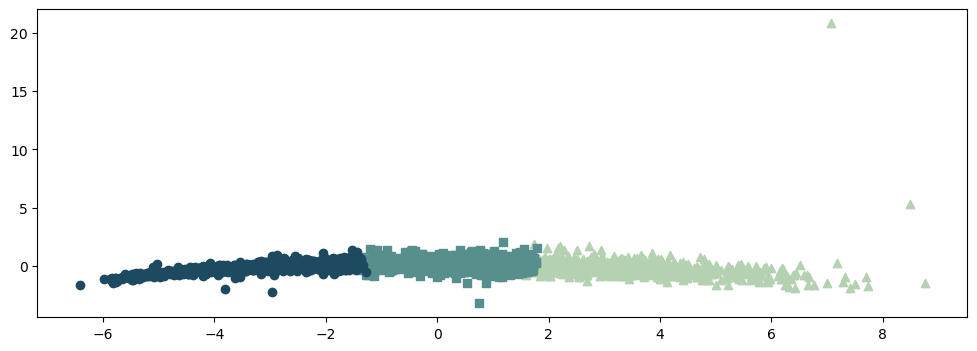

In [73]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X_or.drop(['0', 'Cluster Labels'], axis=1))

for l, c, s in zip(range(3), cluster_colors[:3], cluster_shape[:3]):
    ax.scatter(X_pca[X_or['Cluster Labels'] == l, 0], X_pca[X_or['Cluster Labels'] == l, 1], color=c, marker=s)

plt.show()

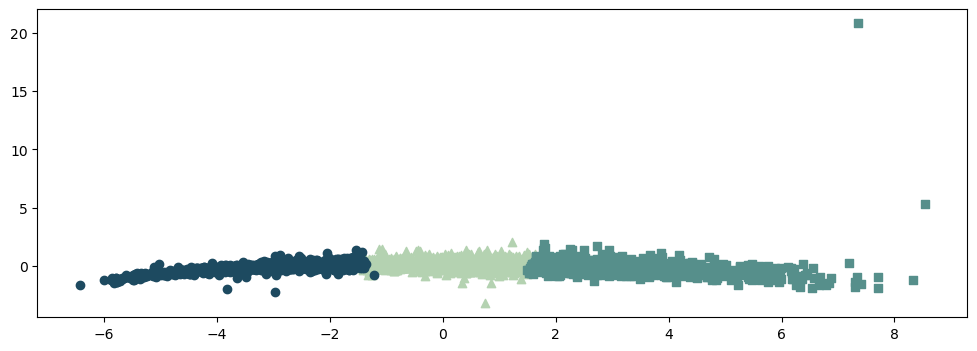

In [74]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X_imp.drop(['0', 'Cluster Labels'], axis=1))

for l, c, s in zip(range(3), cluster_colors[:3], cluster_shape[:3]):
    ax.scatter(X_pca[X_imp['Cluster Labels'] == l, 0], X_pca[X_imp['Cluster Labels'] == l, 1], color=c, marker=s)

plt.show()

Eventually we can swap cluster labels:

In [75]:
def swap(df, column_label, label1, label2):
    labels = df[column_label].values

    for i in range(len(labels)):
        if labels[i] == label1:
            labels[i] = label2
        elif labels[i] == label2:
            labels[i] = label1

    df[column_label] = labels

# Modify from here
swap(X_imp, 'Cluster Labels', 0, 1)

We can now retry to visulize it:

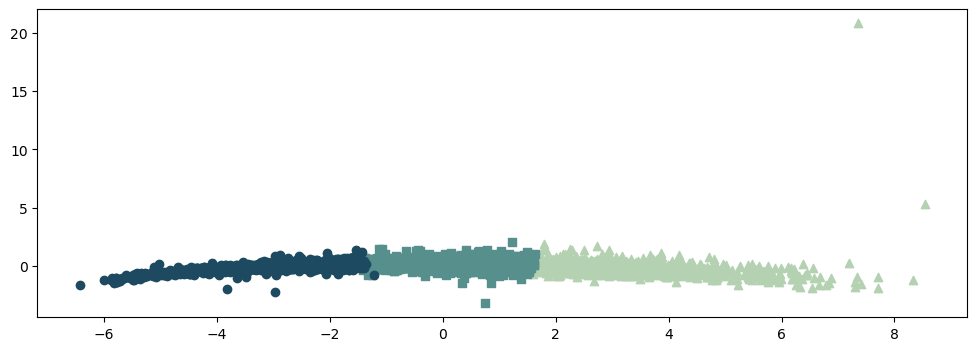

In [76]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X_imp.drop(['0', 'Cluster Labels'], axis=1))

for l, c, s in zip(range(3), cluster_colors[:3], cluster_shape[:3]):
    ax.scatter(X_pca[X_imp['Cluster Labels'] == l, 0], X_pca[X_imp['Cluster Labels'] == l, 1], color=c, marker=s)

plt.show()

### Compute the loss function

In [77]:
original_clusters = X_or['Cluster Labels'].values
imputed_clusters = X_imp['Cluster Labels'].values

N = len(original_clusters)
acc = (original_clusters == imputed_clusters).sum() / N
print(f'Accuracy of {acc:.3f}')

Accuracy of 0.974
